# # データ構造化ハンズオン演習　5-2
## NMR（Bruker）編 



**対応機種** ：　Bruker AV-200  
**rawデータ**：　BrukerはフォルダーにFID, FFTデータが階層的に格納されます　　
**スクリプトの内容**：  
Bruker製NMRのデータについて一次元NMRのデータ構造化およびスペクトル図を出力します．

## サンプルデータを読み込みましょう

In [ ]:
!git clone https://github.com/ARIM-Training/Training_Program_5_2.git
%cd Training_Program_5_2

これで準備が整いました．

<hr>

## 1. ライブラリーを読み込みましょう
最初にコードを走らせるのに必要なライブラリーを読み込みます．  NMRのデータ処理では，``nmrglue``という専用ライブラリを使います．

 * 標準ライブラリー: ``glob``, ``os``, ``re``,``shutil``
 * NMR処理用: ``nmrglue``
 * 数値処理用: ``numpy``
 * 可視化用: ``matplotlib``  
 
 なおGoogle Colabでの動作ではnmrglueをpip installする必要があります．
 
Google Colabの標準ではinstallされていないライブラリは，行頭に「!（エクスクラメーション・マーク）」のあとに「pip install ライブラリ名」で使えるようになります．

ただし，ここでは不用意な実行を避けるために「#」でコメントアウトしています．実際にGoogle Colabで走らせる場合にはコメントアウト（#を削除）して行ってください．


In [1]:
# モジュール
import os

# NMR処理用　
#!pip install nmrglue
import nmrglue as ng

# 数値処理用
import numpy as np
import pandas as pd

# 可視化
from matplotlib import pyplot as plt

また，出力結果を「output」フォルダーに保存するため，そのフォルダーの作成をします．

In [2]:
output_folder = 'output'
os.makedirs(output_folder,exist_ok = True)

# 2. nmrglueの基本動作
``nmrglue``はBrukerやVarianなどの欧米のNMRメーカーのデータはrawデータから読み込めるようになっています．

## 2.1.ファイルの読み込み（FID）
Bruker製のNMRのファイルの読み込みは``nmrglue``のbruker.read()モジュールからfidが含まれるフォルダ名を指定します．  
以下の事例では「data」フォルダーに格納してある「aist21c001」の測定で得られているfidのファイルがある「3」を読み込む場合です．　　
このモジュールを実行し，メタデータを``meta_data``へ，そして数値データは``raw_data``へ返します．

In [89]:
file = 'data/test2111-1H/1'
meta_data, raw_data  = ng.bruker.read(file, bin_file='fid')

### 2.1.1. メタデータ
brukerの``meta_data``はpythonの辞書形式で格納されます．

ここから必要なメタデータを抽出することができます．例えばメタデータの'FILE_SIZE'を見る場合には以下のようにpythonの辞書形式のルールから得ることができます．

In [42]:
meta_data

{'procs': {'_coreheader': ['##TITLE= Parameter file, TOPSPIN\t\tVersion 1.3',
   '##JCAMPDX= 5.0',
   '##DATATYPE= Parameter Values',
   '##ORIGIN= UXNMR, Bruker Analytische Messtechnik GmbH',
   '##OWNER= root'],
  '_comments': ['$$ 2021-09-08 08:59:52.015 +0900  bruker@NMRPC',
   '$$ C:/Bruker/TOPSPIN/data/mhattori/nmr/test2109-1H/1/pdata/1/procs'],
  'ABSF1': 0,
  'ABSF2': 0,
  'ABSG': 0,
  'ABSL': 0,
  'ALPHA': 0,
  'AQORDER': 0,
  'ASSFAC': 0,
  'ASSFACI': 0,
  'ASSFACX': 0,
  'ASSWID': 0,
  'AUNMP': 'proc_1d',
  'AXLEFT': 0,
  'AXRIGHT': 0,
  'AXTYPE': 0,
  'AXUNIT': '',
  'AZFE': 0.1,
  'AZFW': 10,
  'BCFW': 0,
  'BC_mod': 2,
  'BYTORDP': 0,
  'COROFFS': 0,
  'CY': 10,
  'DATMOD': 1,
  'DC': 0,
  'DFILT': '',
  'DTYPP': 0,
  'F1P': 67.3438186645508,
  'F2P': -57.5743209729546,
  'FCOR': 0.5,
  'FTSIZE': 8192,
  'FT_mod': 6,
  'GAMMA': 0,
  'GB': 0,
  'INTBC': 1,
  'INTSCL': 1,
  'ISEN': 30,
  'LB': 0,
  'LEV0': 0,
  'LPBIN': 0,
  'MAXI': 1000,
  'MC2': 0,
  'MEAN': 0,
  'ME_mod'

In [59]:
meta_data['acqus']['NUC1']

'13C'

### 2.1.2. 数値データ
一方で数値データとして格納した``raw_data``は実数部と虚数部を``numpy``のarray配列で返します．

In [90]:
raw_data

array([  0.  +0.j,   0.  +0.j,   0.  +0.j, ..., 660.-125.j, 660.-126.j,
       658.-125.j])

fidを可視化してみましょう．  ``matplotlib``のplotで表示します．

C:\Users\Shigeyuki Matsunami\anaconda3\envs\ARIM\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


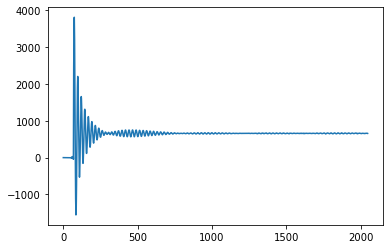

In [91]:
plt.plot(raw_data)
plt.show()

## 2.2. FFT変換
以下の一連の処理はnmrglueにおける定形の処理フローとなります．fidをフーリエ変換をかけたあとオーフォフェイズで自動的に位相をあわせます．ケミカルシフトppmを計算します．

In [92]:
# remove the digital filter
data = ng.bruker.remove_digital_filter(meta_data, raw_data)

# process the spectrum
data = ng.proc_base.zf_size(data, 32768)    # zero fill to 32768 points
data = ng.proc_base.em(data, lb=0.0003)

data = ng.proc_base.fft(data)   

#data = ng.process.proc_autophase.autops(data, 'peak_minima')

data = ng.process.proc_autophase.autops(data, 'acme')

data = ng.proc_base.di(data)                # discard the imaginaries
data = ng.proc_base.rev(data)               # reverse the data

# Set the spectral parameters.
udic = ng.bruker.guess_udic(meta_data, data)
uc = ng.fileiobase.uc_from_udic(udic)
ppm_scale = uc.ppm_scale()

Optimization terminated successfully.
         Current function value: 562.029430
         Iterations: 122
         Function evaluations: 235


横軸のppm_scaleを見るとppmの値が得られます．

In [93]:
ppm_scale

array([ 57.01557914,  57.01176694,  57.00795474, ..., -67.89110705,
       -67.89491925, -67.89873145])

## 2.3. スペクトルの作成（FIDから）
スペクトルの作図はJEOLの場合と大きな違いはありません．

In [94]:
def make_spectrum(data, ppm_scale, output_file_name):

    #　図の設定 
    hfont = {'fontname': 'Arial'}
    fig, ax = plt.subplots(1,1, figsize=(16,9))
             
    ax.plot(ppm_scale,data,
           color ='black',
           linewidth = 0.5
           )
    
    ax.set_yticklabels([])

    #　軸の設定
    ax.minorticks_on()
    ax.tick_params(direction = "in", 
                   which = "both", 
                   length = 5, 
                   labelsize=16)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    ax.axes.yaxis.set_visible(False)

    ax.invert_xaxis()
    ax.set_title(output_file_name, **hfont, fontsize = 16)
    ax.set_xlabel('ppm',**hfont, fontsize = 14)
        
    #出力
    plt.savefig('output/' + output_file_name + '_spectrum.png', dpi=300)
        

実際に図示をしてみます．output_file_name以外は既に処理をおこなっているdata, meta_data, x_scaleを変数として代入します．

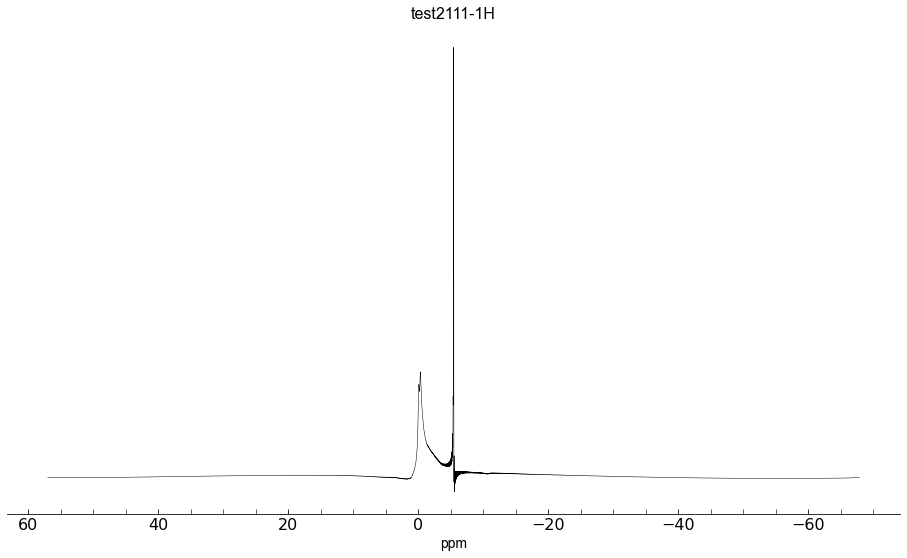

In [95]:
output_file_name = 'test2111-1H'
make_spectrum(data, ppm_scale, output_file_name)

オートフェイズによる位相合わせではピークの形が対称的ではありません．fidからスペクトルを作成する場合，GUIではマニュアル補正をする機能はnmrglueでも備えていますが，データ構造化システムではそれを行うことができません．fidからのデータ登録では位相合わせでネックとなります．

## 2.4.　FFT変換後からの取り込み

In [105]:
# read in the Bruker data
file = 'data/test2111-1H/1/pdata/1/'
meta_data, raw_data = ng.bruker.read_pdata(file)

### 2.4.1　メタデータの表示

In [106]:
meta_data

{'procs': {'_coreheader': ['##TITLE= Parameter file, TOPSPIN\t\tVersion 1.3',
   '##JCAMPDX= 5.0',
   '##DATATYPE= Parameter Values',
   '##ORIGIN= UXNMR, Bruker Analytische Messtechnik GmbH',
   '##OWNER= root'],
  '_comments': ['$$ 2021-11-19 10:01:55.312 +0900  bruker@NMRPC',
   '$$ C:/Bruker/TOPSPIN/data/mhattori/nmr/test2111-1H/1/pdata/1/procs'],
  'ABSF1': 0,
  'ABSF2': 0,
  'ABSG': 0,
  'ABSL': 0,
  'ALPHA': 0,
  'AQORDER': 0,
  'ASSFAC': 0,
  'ASSFACI': 0,
  'ASSFACX': 0,
  'ASSWID': 0,
  'AUNMP': 'proc_1d',
  'AXLEFT': 0,
  'AXRIGHT': 0,
  'AXTYPE': 0,
  'AXUNIT': '',
  'AZFE': 0.1,
  'AZFW': 10,
  'BCFW': 0,
  'BC_mod': 2,
  'BYTORDP': 0,
  'COROFFS': 0,
  'CY': 10,
  'DATMOD': 1,
  'DC': 0,
  'DFILT': '',
  'DTYPP': 0,
  'F1P': 67.3438186645508,
  'F2P': -57.5743209729546,
  'FCOR': 0.5,
  'FTSIZE': 8192,
  'FT_mod': 6,
  'GAMMA': 0,
  'GB': 0,
  'INTBC': 1,
  'INTSCL': 1,
  'ISEN': 30,
  'LB': 0,
  'LEV0': 0,
  'LPBIN': 0,
  'MAXI': 1000,
  'MC2': 0,
  'MEAN': 0,
  'ME_mod'

### 2.4.2　数値部の表示

In [107]:
raw_data

array([-26.57714844,  -8.69824219,  11.03588867, ..., 124.51757812,
       144.0246582 , 178.16357422])

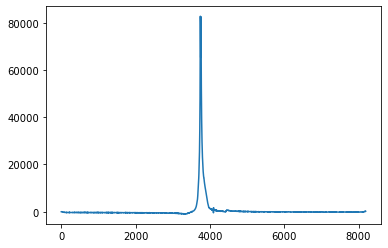

In [108]:
plt.plot(raw_data)
plt.show()

## 2.5. ppm変換

In [109]:
# create a universal dictionary
# I am not familar enough with Bruker data to know if this is a typically how
# spectral parameters are stored in processed data
sw = meta_data['procs']['SW_p']  # spectal width in Hz
obs = meta_data['procs']['SF']   # observation frequences in MHz
carrier = meta_data['procs']['OFFSET'] * obs - (sw / 2.) # carrier freq in Hz

udic = ng.bruker.guess_udic(meta_data, raw_data)
udic[0]['size']     = raw_data.shape[0]
udic[0]['complex']  = True
udic[0]['encoding'] = 'direct'
udic[0]['sw']       = sw
udic[0]['obs']      = obs
udic[0]['car']      = carrier
udic[0]['label']    = '1H'
udic[0]['freq']     = True
udic[0]['time']     = False

C:\Users\Shigeyuki Matsunami\anaconda3\envs\ARIM\lib\site-packages\nmrglue\fileio\bruker.py:92: UserWarning: Failed to determine udic parameters for dim: 0
  warn("Failed to determine udic parameters for dim: %i" % (b_dim))


In [110]:
# create a unit conversion object for the direct dimension
uc = ng.fileiobase.uc_from_udic(udic)
ppm_scale = uc.ppm_scale()

In [111]:
ppm_scale

array([ 57.01558   ,  57.00033121,  56.98508241, ..., -67.8567964 ,
       -67.8720452 , -67.88729399])

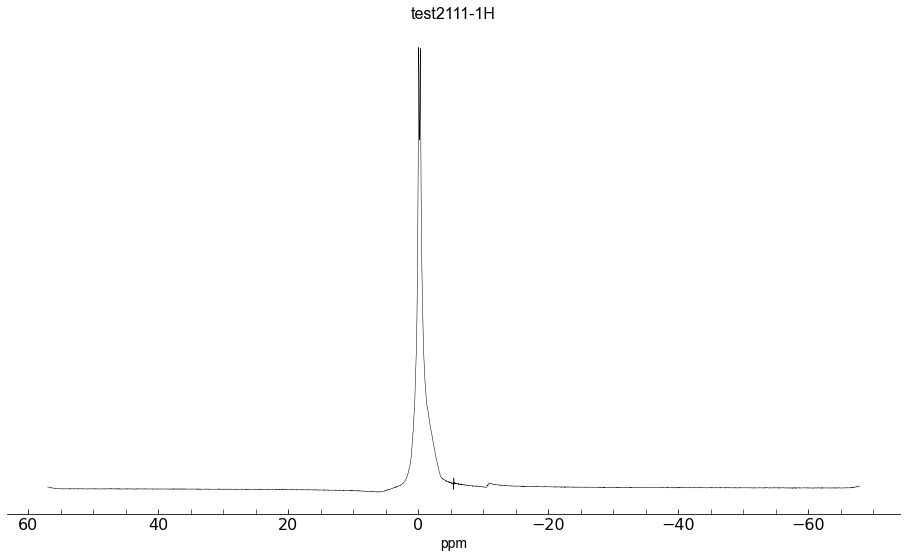

In [112]:
output_file_name = 'test2111-1H'
make_spectrum(raw_data, ppm_scale, output_file_name)

## 3. ピークピッキング
### 3.1 ピークサーチ
peakリストは強度のしきい値を定めて出力することができます．ここでは最大強度の1/20をしきい値としてピークピッキングを行う処理の流れについて説明をします．  

In [166]:
#しきい値の設定
threshold = max(raw_data)*0.2

ピークサーチはnmrglueの``peakpick.pick``モジュールを用います．  
第一引数としては，ピークサーチを対象とするデータ（ここではdata.real）を指定し，第二引数には強度のしきい値をセットします．

In [167]:
peaks = ng.peakpick.pick(raw_data, pthres=threshold, algorithm="downward")

In [168]:
peaks

rec.array([(12046., 1, 22.45387831, 4.63594635e+08),
           (20828., 2, 51.77507323, 1.31424958e+09),
           (20772., 2, 52.8298174 , 8.37290735e+08),
           (20883., 2, 14.        , 8.48379436e+07)],
          dtype=[('X_AXIS', '<f8'), ('cID', '<i4'), ('X_LW', '<f8'), ('VOL', '<f8')])

### 3.2 ピッキングしたピークの可視化

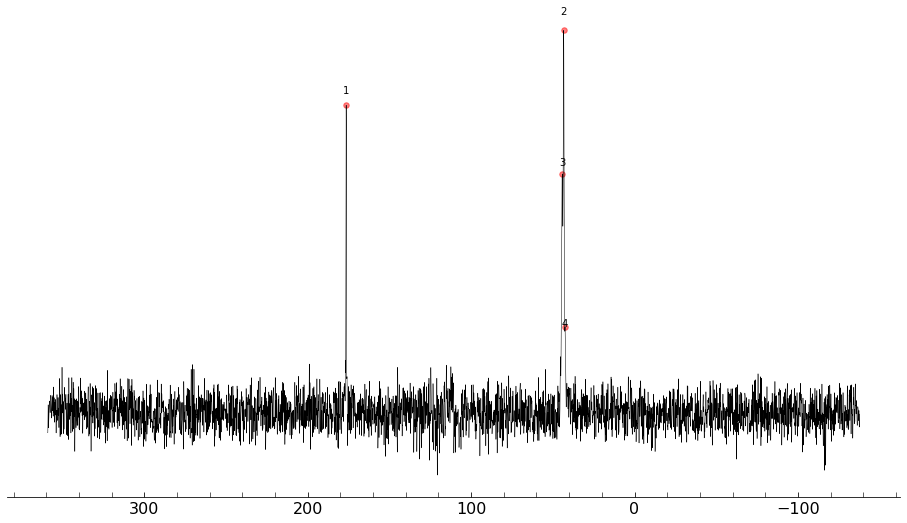

In [172]:
#　スペクトル図
hfont = {'fontname': 'Arial'}
fig, ax = plt.subplots(1,1, figsize=(16,9))
             
ax.plot(ppm_scale,raw_data, 
        color ='black',
        linewidth = 0.5
        )

ax.invert_xaxis()

#　軸の設定
ax.minorticks_on()
ax.tick_params(direction = "in", 
                   which = "both", 
                   length = 5, 
                   labelsize=16)
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
    
ax.axes.yaxis.set_visible(False)


# マーカーの付与
height_list = []
ppm_list = []

for n, peak in enumerate(peaks):
    height = raw_data[int(peak["X_AXIS"])]
    ppm = uc.ppm(peak["X_AXIS"])
    
    ax.scatter(ppm, height, marker="o", color="r", s=30, alpha=0.5)
    ax.text(ppm, height*1.05, n + 1, ha="center", va="center")
    
    height_list.append(height)
    ppm_list.append(ppm)

## 3.3　ピークテーブルの作成
上記でマークしたピークを表形式にまとめます．

In [173]:
peak_list = pd.DataFrame(list(zip(ppm_list,height_list)), columns = ['ppm','height'])
peak_list.index = peak_list.index + 1

print(f'ピークの本数は {len(peak_list)} です')

peak_list

ピークの本数は 4 です


,ppm,height
1,176.485587,2.112608e+07
2,43.342190,2.629130e+07
3,44.191203,1.638257e+07
4,42.508338,5.837978e+06
